In [1]:
import numpy as np
import pandas as pd
import warnings
import numpy as np
from itertools import product
from turtle import shape
import pygad
import matplotlib.pyplot as plt
from matplotlib import ticker
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = ['sans-serif']   
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

data = pd.read_excel('酶复配数据集.xlsx') 

data = data.drop_duplicates()


In [2]:
enzyme1, assistant1 = 'Ba', 'AKD'
enzyme2, assistant2 = 'XYN', 'AKD'


data_index1 = (data['酶'] == enzyme1) & (data['助剂'] == assistant1)
data_index2 = (data['酶'] == enzyme2) & (data['助剂'] == assistant2)

In [3]:
label_encoder = LabelEncoder()
data['酶'] = label_encoder.fit_transform(data['酶'])
data['助剂'] = label_encoder.fit_transform(data['助剂'])

<Axes: >

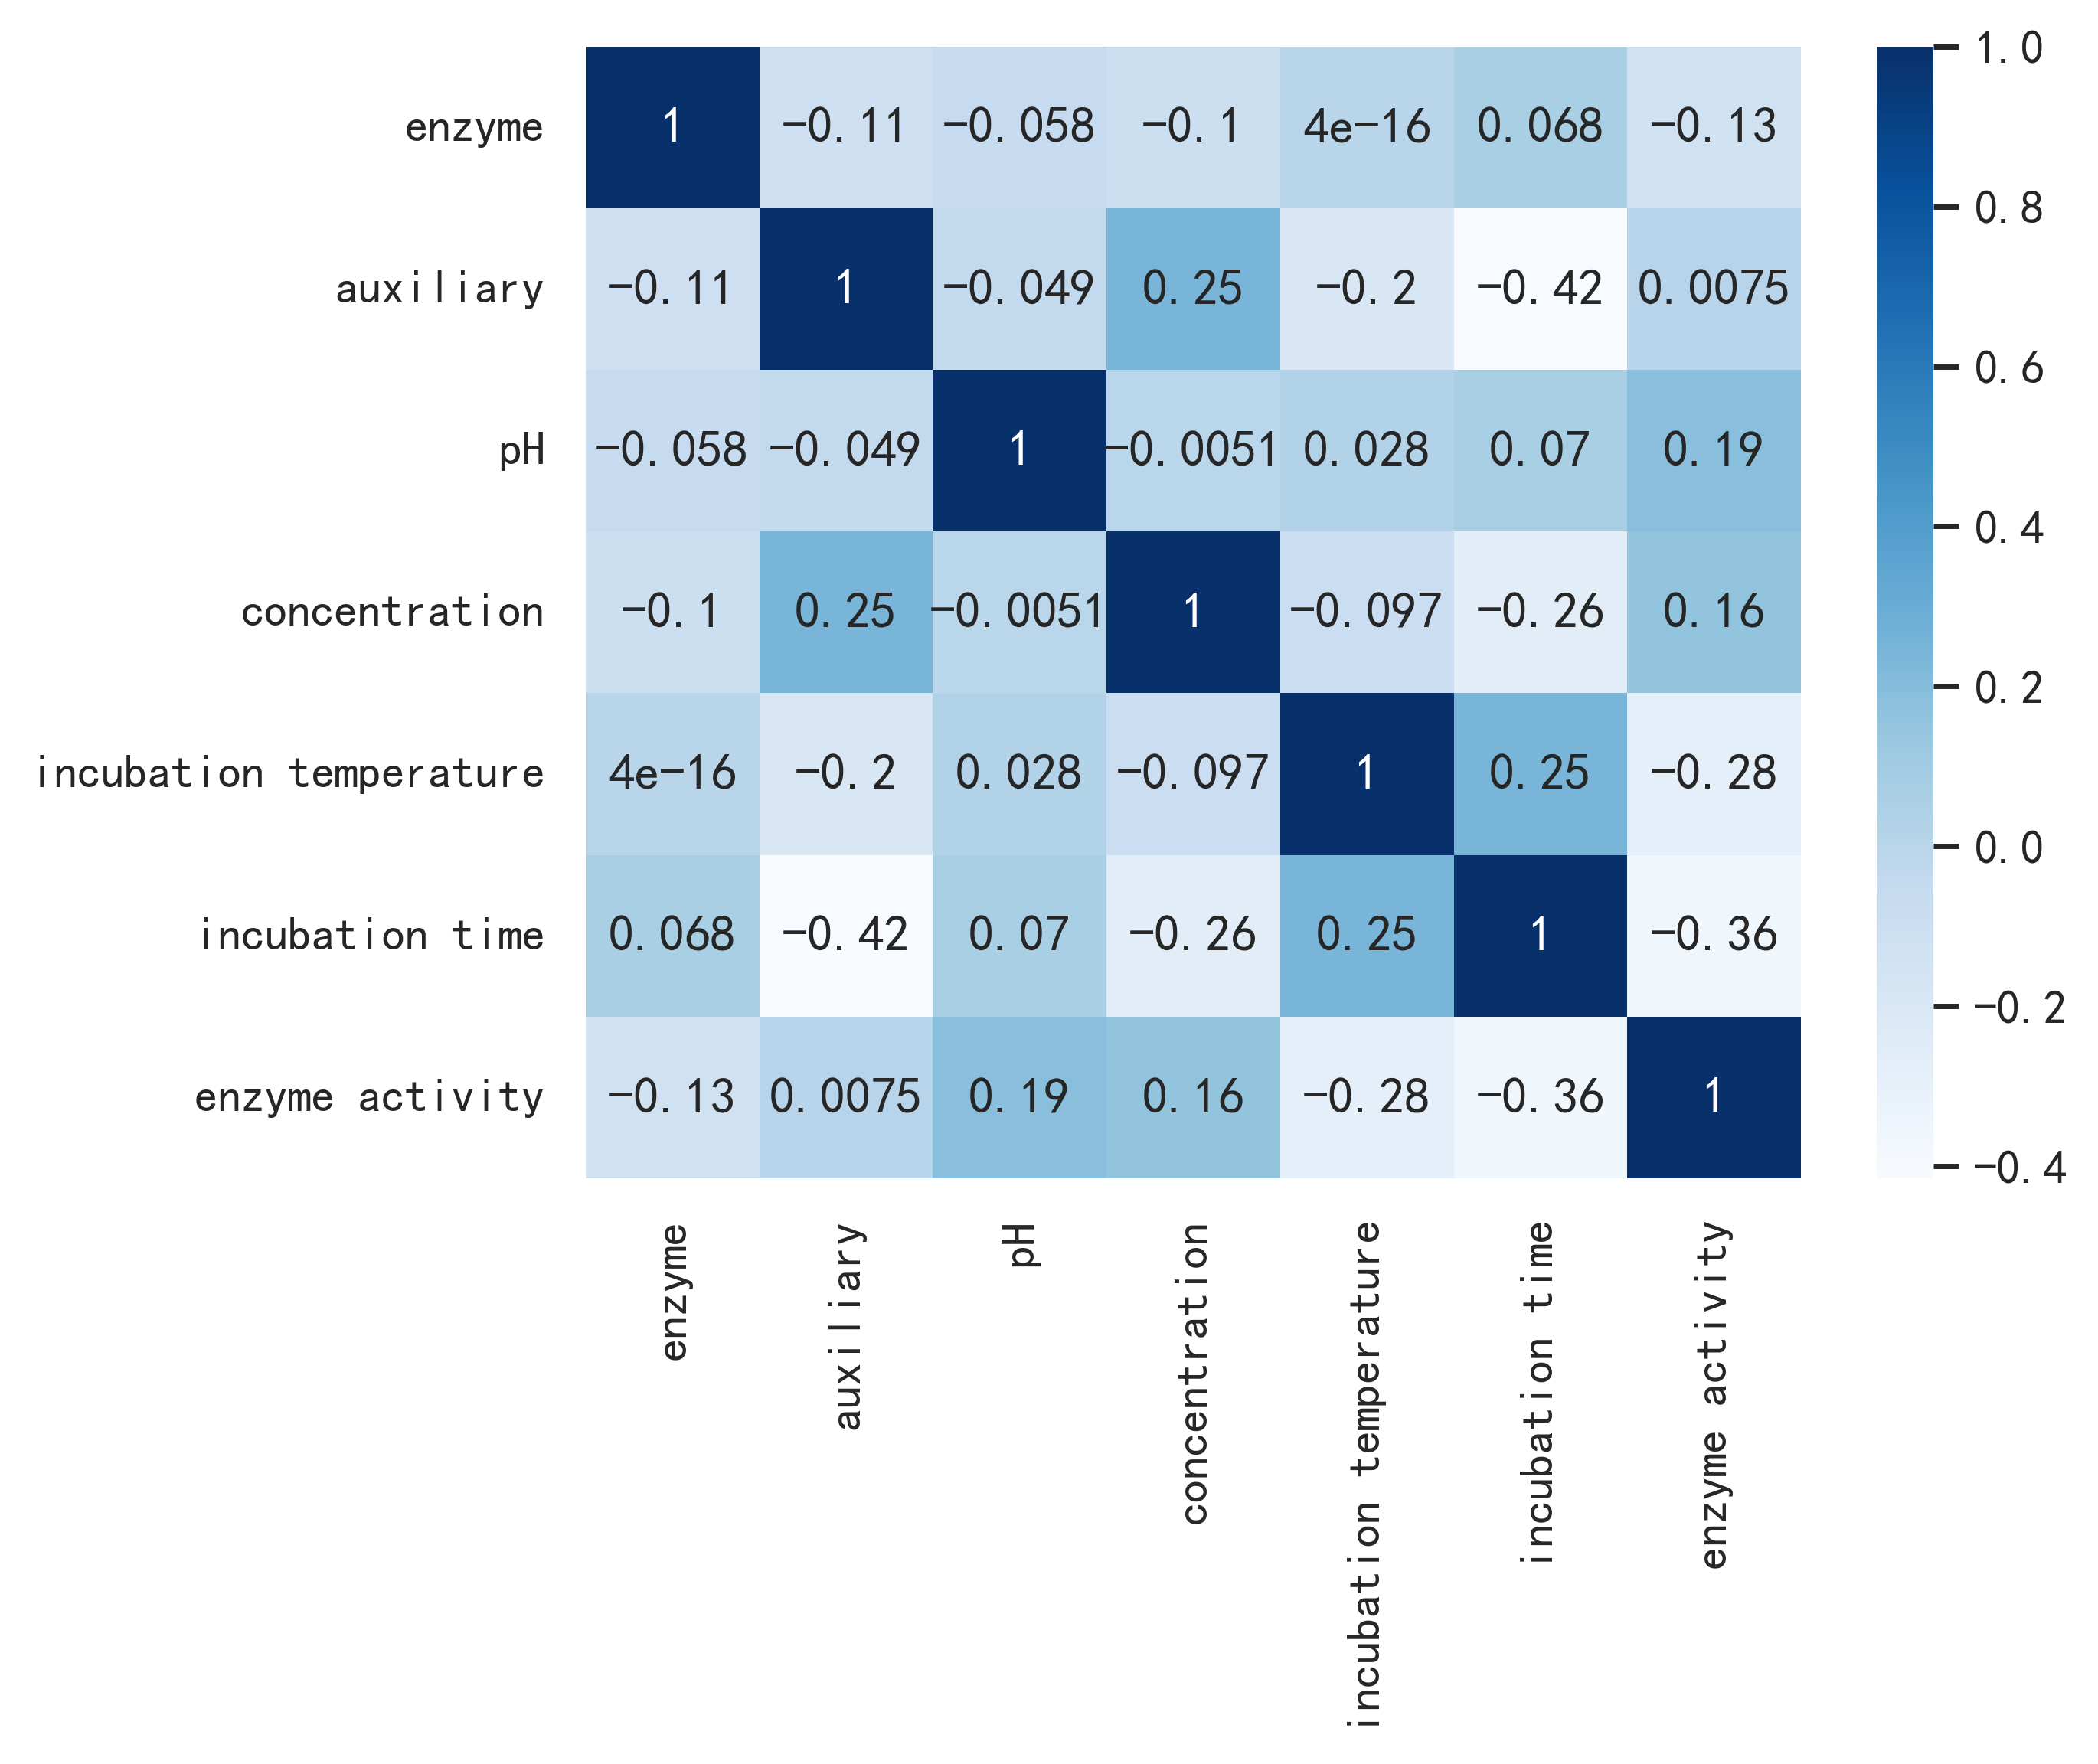

In [4]:
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False  
sns.set(font='SimHei') 
data_2 = pd.read_excel('酶复配数据集.xlsx')
data_2['酶'] = label_encoder.fit_transform(data_2['酶'])
data_2['助剂'] = label_encoder.fit_transform(data_2['助剂'])
data_2 = data_2.rename(columns={'酶': 'enzyme'})
data_2 = data_2.rename(columns={'助剂':'auxiliary'})
data_2 = data_2.rename(columns={'浓度':'concentration'})
data_2 = data_2.rename(columns={'孵育温度':'incubation temperature'})
data_2 = data_2.rename(columns={'孵育时间':'incubation time'})
data_2 = data_2.rename(columns={'酶活':'enzyme activity'})
features_all2 = data_2.corr()    
plt.figure(dpi=400)
ax = sns.heatmap(features_all2,cmap = 'Blues',annot =True )
sns.set_theme(style="whitegrid",font='Times New Roman',font_scale=1.5)
plt.savefig('BR模型单酶预测热力图.jpg', dpi=600, bbox_inches='tight')
ax

In [5]:
x_ = data.drop(columns=['酶活'], axis=1)
y_ = data['酶活']
scaler = MinMaxScaler()
scaler.fit(x_) 
x_transfer = scaler.transform(x_) 
x_train_,x_test_,y_train_,y_test_ = train_test_split(x_transfer,y_,test_size = 0.2,random_state = 44) 

In [6]:
BRR_ = BayesianRidge(n_iter=300, tol=0.001, alpha_1=1e-06, alpha_2=1e-06, lambda_1=1e-06, 
                     lambda_2=1e-06, alpha_init=None, lambda_init=None, compute_score=False,
                     fit_intercept=True,copy_X=True, verbose=False)
BRR_model_ = BRR_.fit(x_train_, y_train_)

In [7]:
pre1 = BRR_model_.predict(x_train_)
pre2 = BRR_model_.predict(x_test_)
R2_1 = r2_score(y_train_,pre1)
R2_2 = r2_score(y_test_,pre2)
print("train_model's R2: {:.4f}".format(R2_1))
print("test_model's R2: {:.4f}".format(R2_2))
mse_train_ = np.mean(np.power(y_train_ - pre1, 2))
mse_test_ = np.mean(np.power(y_test_ - pre2, 2))
print("train_model's MSE: {:.4f}".format(mse_train_))
print("test_model's MSE: {:.4f}".format(mse_test_))
print("train_model's RMSE:",np.sqrt(metrics.mean_squared_error(y_train_,pre1)))
print("test_model's RMSE:",np.sqrt(metrics.mean_squared_error(y_test_,pre2)))

train_model's R2: 0.2704
test_model's R2: 0.2216
train_model's MSE: 0.1089
test_model's MSE: 0.0794
train_model's RMSE: 0.32996936101853874
test_model's RMSE: 0.28183239444496266


In [8]:
data1 = data[data_index1]
data2 = data[data_index2]
X1 = data1[['pH', '浓度', '孵育温度', '孵育时间']]
X2 = data2[['pH', '浓度', '孵育温度', '孵育时间']]
y1 = data1['酶活']
y2 = data2['酶活']


In [9]:
def used_model(X_train, y_train): 
    BRR = BayesianRidge(n_iter=300, tol=0.001, alpha_1=1e-06, alpha_2=1e-06, lambda_1=1e-06, 
                     lambda_2=1e-06, alpha_init=None, lambda_init=None, compute_score=False,
                     fit_intercept=True,copy_X=True, verbose=False)
    BRR_model = BRR.fit(X_train, y_train)
    return BRR_model
    # 返回模型

In [10]:
def remove_duplicates(arr):
    _, idx = np.unique(arr, axis=0, return_index=True)
    return arr[np.sort(idx)]

def gaga(gp, gp2):
    last_fitness = 0

    def fitness_func(index, solution, solution_idx):
        pred = gp.predict([solution])
        pred2 = gp2.predict([solution])
        Z = pred[0]+pred2[0]
        return Z

    def on_generation(ga_instance):
        global last_fitness
        last_fitness = ga_instance.best_solution(
            pop_fitness=ga_instance.last_generation_fitness)[1]

    last_fitness = 0
    # 调用pygad
    ga_instance = pygad.GA(num_generations=100,  # 可调参数
                           num_parents_mating=8,  # 可调参数
                           sol_per_pop=10,  # 可调参数
                           num_genes=4,
                           crossover_type="single_point",
                           mutation_type="random",
                           mutation_percent_genes='default',
                           # 此处可挑输出指标数值范围 range(7, 9, 1) 为pH的取值范围 7最小 9最大 1为步长 若要步长为小数应把range换np.arange
                           gene_space=[range(7, 9, 1), np.arange(0.001, 0.1, 0.002), range(30, 80, 10), range(20, 80, 10)],
                           mutation_by_replacement=True,
                           fitness_func=fitness_func,
                           on_generation=on_generation,
                           save_solutions=True,
                           random_seed=36)

    ga_instance.run()
    ga_instance.plot_result()
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    ga_s = np.array(ga_instance.solutions)
    ga_sf = np.array(ga_instance.solutions_fitness)
    ga_res = np.c_[ga_s,ga_sf]
    sort_idx = np.argsort(ga_res[:, 4])[::-1]
    # 使用sort_idx对原数组进行重排
    sorted_arr = ga_res[sort_idx]
    sorted_arr = remove_duplicates(sorted_arr)
    nums_pf = 15  # 前几个配方  可改参数
    score = sorted_arr[:nums_pf, 4]
    score = (score / score[0]) * 100
    print('输入的酶和助剂分别为：')
    print(enzyme1, assistant1)
    print(enzyme2, assistant2)
    print("最佳反应条件为 pH:{}, 浓度:{:.2f}, 温度:{}, 孵育时间:{}".format(solution[0], solution[1],solution[2],solution[3]))
    print('----------------------------------')
    print('推荐反应条件')
    print('pH\t 浓度\t\t 温度\t 孵育时间\t 评分')
    for i in range(nums_pf):
        print(sorted_arr[i][0], '\t', '{:.4f}'.format(sorted_arr[i][1]), '\t',
              sorted_arr[i][2], '\t', sorted_arr[i][3], '\t''\t',
              '{:.2f}'.format(score[i]))


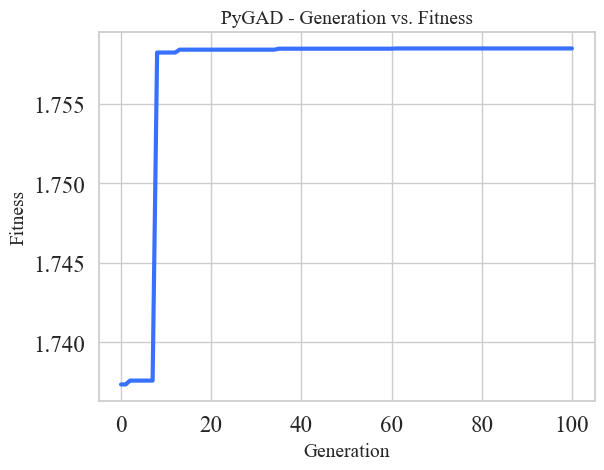

输入的酶和助剂分别为：
Ba AKD
XYN AKD
最佳反应条件为 pH:8.0, 浓度:0.10, 温度:30.0, 孵育时间:20.0
----------------------------------
推荐反应条件
pH	 浓度		 温度	 孵育时间	 评分
8.0 	 0.0970 	 30.0 	 20.0 		 100.00
8.0 	 0.0950 	 30.0 	 20.0 		 100.00
8.0 	 0.0930 	 30.0 	 20.0 		 100.00
8.0 	 0.0910 	 30.0 	 20.0 		 100.00
8.0 	 0.0890 	 30.0 	 20.0 		 100.00
8.0 	 0.0870 	 30.0 	 20.0 		 100.00
8.0 	 0.0850 	 30.0 	 20.0 		 99.99
8.0 	 0.0830 	 30.0 	 20.0 		 99.99
8.0 	 0.0810 	 30.0 	 20.0 		 99.99
8.0 	 0.0790 	 30.0 	 20.0 		 99.99
8.0 	 0.0770 	 30.0 	 20.0 		 99.99
8.0 	 0.0750 	 30.0 	 20.0 		 99.99
8.0 	 0.0710 	 30.0 	 20.0 		 99.99
8.0 	 0.0690 	 30.0 	 20.0 		 99.99
8.0 	 0.0650 	 30.0 	 20.0 		 99.99


In [11]:
gp1 = used_model(X1, y1)
gp2 = used_model(X2, y2)
gaga(gp1, gp2)


model's R2: 0.1137
model's MSE: 0.0747
model's RMSE: 0.27326961139695666


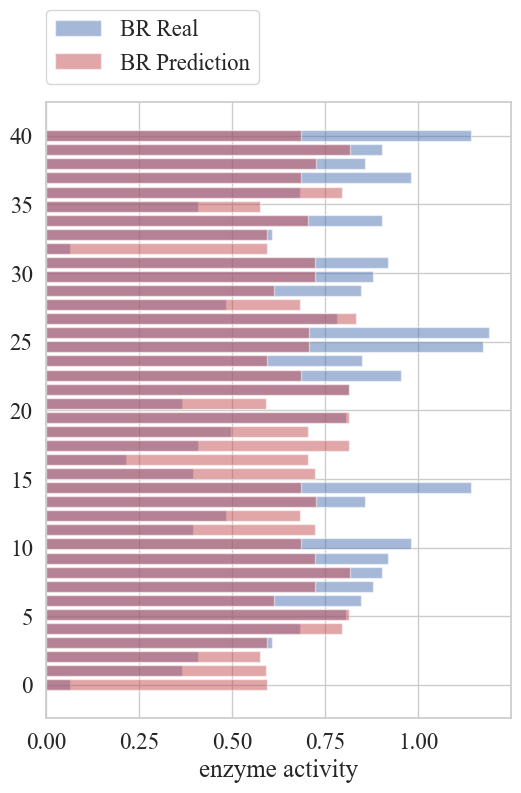

In [12]:
from sklearn.metrics import r2_score
pre1 = gp1.predict(X1)
pre2 = gp1.predict(X2)
pre = np.concatenate((pre1, pre2))
y = np.concatenate((y1, y2))

R2 = r2_score(y,pre)
SSR = np.sum((y-pre)**2)
SST = np.sum((y-np.mean(y))**2)
r2 = 1 - SSR/(SST+1e-9)
print("model's R2: {:.4f}".format(r2))
mse_test = np.mean(np.power(y - pre, 2))
print("model's MSE: {:.4f}".format(mse_test))
print("model's RMSE:",np.sqrt(metrics.mean_squared_error(y,pre)))


fig = plt.figure(figsize=(6,8))
x = np.linspace(0,y.shape[0],y.shape[0])
plt.barh(x,y,color='b',alpha=0.5,label='BR Real')
plt.barh(x,pre, color = 'r',alpha=0.5,label='BR Prediction')
plt.xlabel("enzyme activity")
plt.legend(bbox_to_anchor=(0, 1.15), loc=2, borderaxespad=0)
plt.savefig('BR模型多酶预测柱状图.jpg', dpi=600, bbox_inches='tight')
plt.show()

In [13]:
data_seaborn = pd.DataFrame()
data_seaborn['enzyme activity_true'] = y
data_seaborn['enzyme activity_pred'] = pre

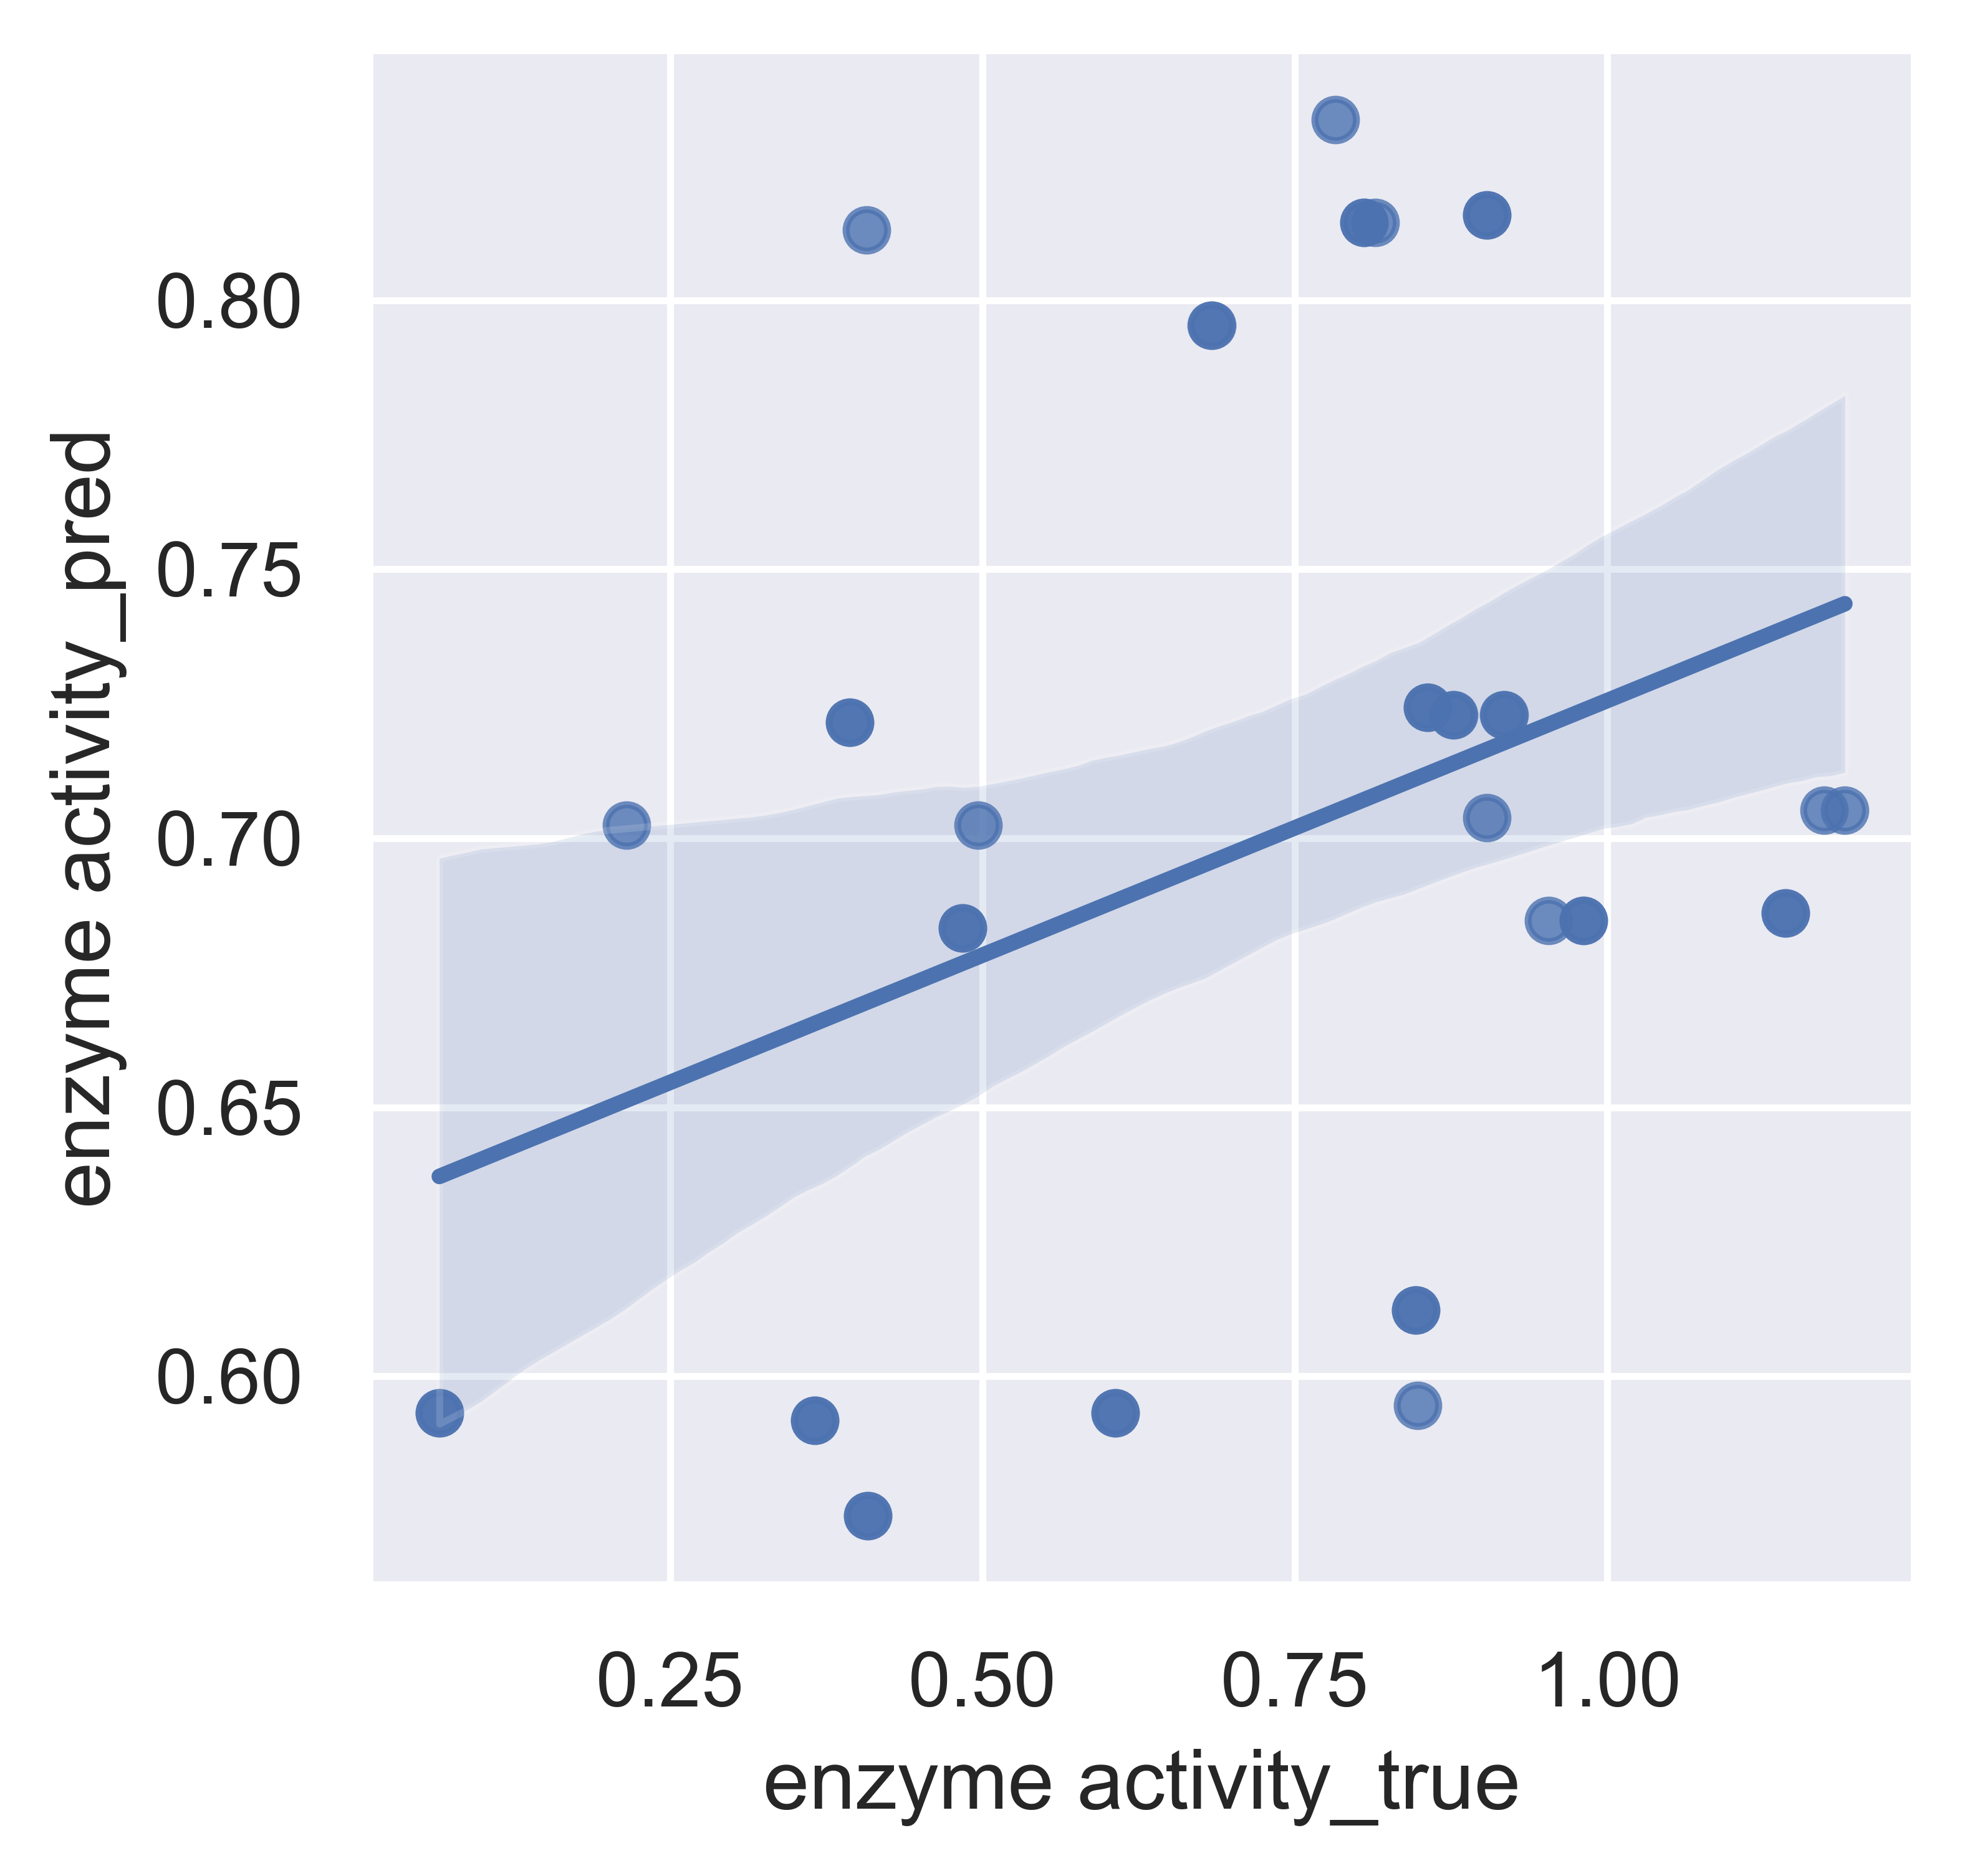

In [14]:
plt.rcParams['font.sans-serif']=['SimHei'] 
plt.rcParams['axes.unicode_minus']=False 
plt.figure(dpi=800, figsize=(4,4))
sns.set(font='SimHei')
sns.set(color_codes=True)
sns.regplot(x=data_seaborn['enzyme activity_true'],y=data_seaborn['enzyme activity_pred'])
plt.savefig('BR模型多酶预测线性回归图.jpg', dpi=600, bbox_inches='tight')